In [1]:
%matplotlib inline

import numpy as np 
import os 
import sys 

import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
from crick import TDigest


path = "/home/b/b382291/git/one_pass"
sys.path.append(path)
os.chdir(path)

from one_pass.opa import *
from one_pass.opa import Opa

! hostname

l40671.lvt.dkrz.de


In [2]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )

In [3]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
ds = cat.IFS['IFS_4.4-FESOM_5-cycle3']['2D_1h_native'].to_dask() # load medium-resolution here, monthly means
ds_u100 = ds['100u']
ds_v100 = ds['100v']
ds = np.sqrt(ds_u100**2 + ds_v100**2)

In [4]:
# take 1 time step
ds_ll = ds.pipe(attach_coords).isel(time=0)
ds_ll

<xarray.DataArray (value: 26306560)>
dask.array<getitem, shape=(26306560,), dtype=float64, chunksize=(26306560,), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 89.97 89.97 89.97 89.97 ... -89.97 -89.97 -89.97
    lon      (value) float64 0.0 18.0 36.0 54.0 72.0 ... 288.0 306.0 324.0 342.0
    time     datetime64[ns] 2020-01-20
Dimensions without coordinates: value

# convering to lat lon grid 

In [5]:
ds

<xarray.DataArray (time: 43394, value: 26306560)>
dask.array<sqrt, shape=(43394, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2025-01-01
Dimensions without coordinates: value

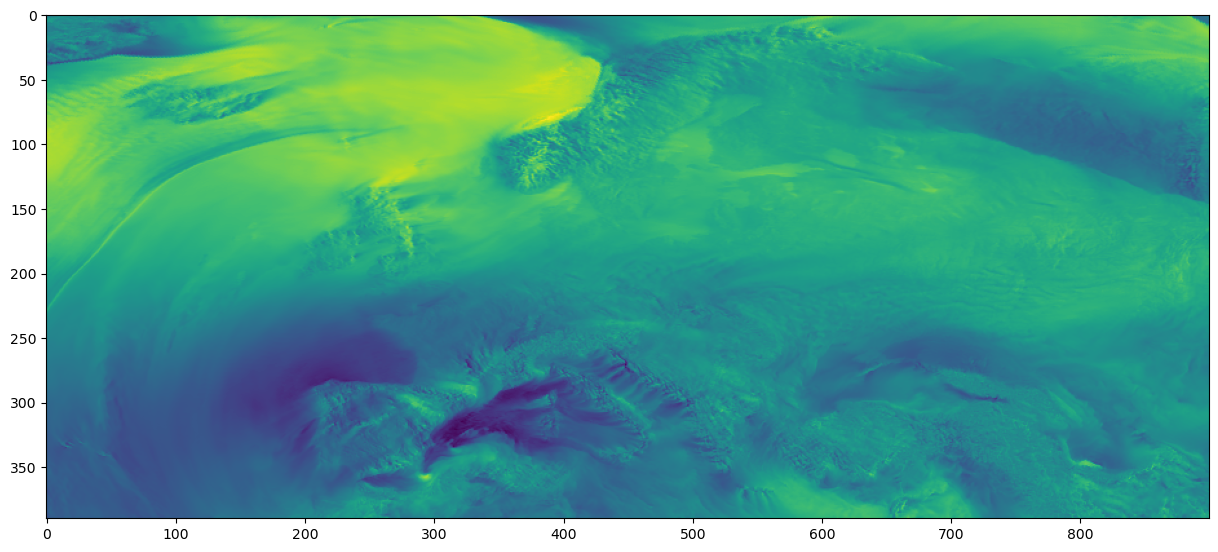

In [8]:
model_lon = ds.lon.values
model_lat = ds.lat.values
nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
lat_nonan = model_lat[nonan]
lon_nonan = model_lon[nonan]
lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)
points_ifs = np.vstack((lon_nonan, lat_nonan)).T

lon = np.linspace(-30, 60, 90*10)
lat = np.linspace(33, 72, (72-33)*10)
lon2, lat2 = np.meshgrid(lon, lat)

data_sample = ds[1,:]

nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan])
interpolated_nn = nn_interpolation((lon2, lat2))

plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

In [36]:
time_series = np.zeros(169)


In [28]:

## creating data 

def closest_value(input_list, input_value):
  arr = np.asarray(input_list)
  i = (np.abs(arr - input_value)).argmin()
  return arr[i]

model_lon = ds.lon.values
model_lat = ds.lat.values

target_lat = 58.235395
target_lon = -2.773114

target_lon_new = closest_value(model_lon, target_lon)
target_lat_new = closest_value(model_lat, target_lat)

nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
lat_nonan = model_lat[nonan]
lon_nonan = model_lon[nonan]
lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)
points_ifs = np.vstack((lon_nonan, lat_nonan)).T

lon = np.linspace(-30, 60, 90*10)
lat = np.linspace(33, 72, (72-33)*10)
lon2, lat2 = np.meshgrid(lon, lat)


time_series = np.zeros(169)

for i in range(169):
    data_sample = ds[i,:]
    nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan])
    interpolated_nn = nn_interpolation((target_lon, target_lat))
    time_series[i] = interpolated_nn
# Find the index of the target (lat, lon) in the unstructured grid
#target_index = np.where((model_lat == target_lat_new) & (model_lon == target_lon_new) & nonan)[0][0]

# Extract the value at the target (lat, lon) location
#target_value = data_sample.values[target_index]

In [30]:
file_path = '/home/b/b382291/git/data/time_series_gif_new.nc'
xr_timeseries = xr.DataArray(time_series)
xr_timeseries.to_netcdf(path = file_path, mode = 'w')

In [2]:
file_path = '/home/b/b382291/git/data/time_series_gif_new.nc'
time_series = xr.open_dataarray(file_path)
time_series = time_series.values 

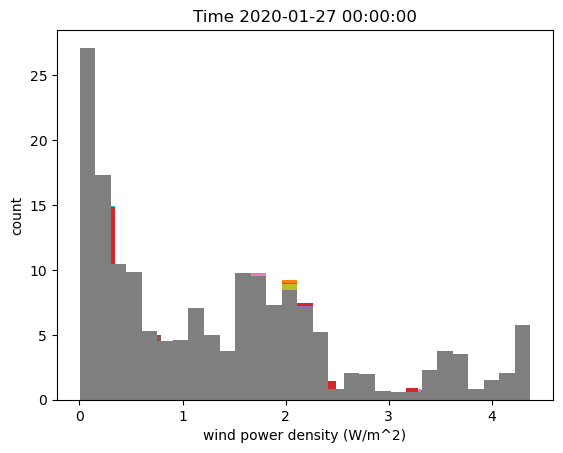

In [8]:

wpd = (0.5*1.225*time_series**3)/1000

bins_space = 30 #np.linspace(0, 10, 30)
#u_1d = np.resize(data_sample, np.size(data_sample))
n = np.size(time_series)
dictlist = [dict() for x in range(n)]    
digest = TDigest() 

tvec = np.arange(np.datetime64('2020-01-20'), np.datetime64('2020-01-28'),dtype='datetime64[h]')

for i in range(169):
    # call the same function with different data in parallel
    digest.update(wpd[i])
    
    if (np.mod(i, 1) == 0 and i > 0):

        hist_data = digest.histogram(bins_space, [digest.min(), digest.max()])
        
        #hist_data[1] = 0.5*1.225*hist_data[1]**3
        bins =  hist_data[1]
        weights = hist_data[0]
        #hist_data[1] = bins
        
        plot_loc = np.where(weights != 0)

        bins_new = bins[plot_loc]
        weights_new = weights[plot_loc]

        plt.hist(bins_new, bins = bins_new, weights = weights_new)
        plt.xlabel('wind power density (W/m^2)')
        plt.ylabel('count')
        plt.title(f'Time {pd.Timestamp(tvec[i])}')  # Set the title for the current frame

        dictlist[i] = hist_data

In [4]:
dictlist[100]

(array([ 2.02829004,  0.59658336,  0.43799272,  0.44867385,  4.84317955,
         5.71079619,  3.97699048,  3.94417286,  1.95364575,  3.66771113,
         2.32123903,  3.74473441,  4.39318439,  2.05351041,  1.58989851,
         3.81594207,  3.80151517,  2.9994783 ,  4.28041579,  2.56285472,
         3.13926463,  0.78417094,  4.66448886,  6.63162672,  9.11625055,
        11.74586018,  3.55033193,  0.54081215,  0.57187454,  1.08451077]),
 array([ 1.24034507,  1.78870032,  2.33705557,  2.88541082,  3.43376607,
         3.98212131,  4.53047656,  5.07883181,  5.62718706,  6.1755423 ,
         6.72389755,  7.2722528 ,  7.82060805,  8.3689633 ,  8.91731854,
         9.46567379, 10.01402904, 10.56238429, 11.11073953, 11.65909478,
        12.20745003, 12.75580528, 13.30416053, 13.85251577, 14.40087102,
        14.94922627, 15.49758152, 16.04593677, 16.59429201, 17.14264726,
        17.69100251]))

MovieWriter Pillow unavailable; using Pillow instead.


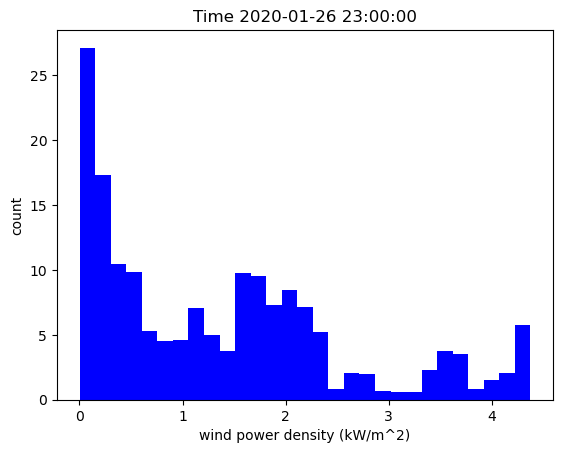

In [9]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

frame_data = dictlist  # Your list of frame data
tvec = np.arange(np.datetime64('2020-01-20'), np.datetime64('2020-01-28'),dtype='datetime64[h]')

fig, ax = plt.subplots()

def update(frame):
    
    ax.clear()  # Clear the previous frame
    hist_data = frame_data[frame+1]  # Get the data for the current frame

    bins = hist_data[1]
    weights = hist_data[0]
    
    #bins = 0.5*1.225*bins**3

    plot_loc = np.where(weights != 0)

    bins_new = bins[plot_loc]
    weights_new = weights[plot_loc]

    _, _, patches = ax.hist(bins_new, bins = bins_new, weights = weights_new, color = 'b')
    ax.set_xlabel('wind power density (kW/m^2)')
    #ax.set_xlabel('100 m wind speed (m/s)')
    ax.set_ylabel('count')
    ax.set_title(f'Time {pd.Timestamp(tvec[frame])}')  # Set the title for the current frame
    
    return patches  # Return the modified patches

animation = FuncAnimation(fig, update, frames=len(frame_data)-1, interval=100, blit=True)

#file_path = '/home/b/b382291/git/one_pass/histogram_wind_speed.gif'
file_path = '/home/b/b382291/git/one_pass/histogram_wpd.gif'
animation.save(file_path, writer='Pillow', fps=6.25)

# aleks code 

In [ ]:
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
tvec = np.arange(np.datetime64('21-06-01'), np.datetime64('21-06-10'),dtype='datetime64[h]')
x = []
for i in range(len(tvec)):
    x.append(str(tvec[i]).replace('-',''))

fig = plt.figure(constrained_layout=True,figsize=(20,5))
fig.subplots_adjust(bottom=0.14, top=0.90, left=0.05, right=0.95)
nrow = 1
ncol = 1
outer = gs.GridSpec(nrow,ncol,wspace=0.01,hspace=0.02)

ax = plt.subplot(outer[0])
line, = ax.plot([], [], label='wpd', c='darkred', linewidth=3)

#ax.plot(tvec,wpd,label='wpd',c='darkred',linewidth=3)

ax.set_ylabel('WPD (W $m^{-2}$)',fontsize=18)
#ax.set_xlabel('Time (hours)',fontsize=18)
ax.set_title('WPD at Moray East (58.2354 N, -2.7731 E)',fontsize=20)
#ax.legend(fontsize=16)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.tick_params(axis='both',labelsize=18)
ax.tick_params(axis='x',rotation=30,labelsize=16)
#ax.set_xticklabels(rotation=45,labels=tvec,fontsize=16,ha='right')
ax.set_xlim([np.datetime64('21-06-01'), np.datetime64('21-06-10')])
ax.set_ylim([0, 1200])
ax.grid(ls='--',color='gray',alpha=0.5)

def update(frame):
    line.set_data(tvec[:frame], wpd[:frame])
    return line,

ani = FuncAnimation(fig, update, frames=len(tvec), interval=100, blit=True)
# save animation to file
ani.save('./plots/timeseries/wpd_ICON_North_Sea.gif', fps=6.25)

In [82]:
time_series

array([5.06960625, 4.71633092, 4.25546399, 3.59332822, 3.47470339,
       4.12210902, 4.54740417, 4.54120722, 4.78902712, 5.08324737,
       5.23940506, 5.42580052, 5.12795805, 5.25596913, 5.79385098,
       7.08389822, 6.32312073, 6.03817114, 6.58392093, 6.89755032,
       6.74145265, 6.85751543, 7.549286  , 6.021726  , 6.05307579,
       5.81477054, 5.50643389, 5.46357267, 5.48186277, 5.91645808,
       6.16399571, 6.75804352, 6.71425059, 6.93988877, 6.66996344,
       6.30280232, 5.42832519, 5.30875522, 5.40806376, 6.00725176,
       5.4201525 , 5.21787279, 5.85904125, 5.89730239, 5.96133502,
       5.86589534, 5.9762145 , 6.05233045, 6.38204702, 6.92088961,
       7.07706622, 7.17020549, 7.09778527, 7.58818598, 7.73189231,
       7.58939137, 7.26021703, 7.38791678, 7.25113824, 7.31614435,
       7.18868532, 7.34242348, 7.29528056, 7.24098714, 7.25302386,
       6.78773911, 6.62019782, 6.77463207, 6.54625524, 6.22922359,
       6.04255177, 6.18117977, 6.65140476, 6.59396963, 6.21419